# GSE161529 OBS Notebook

## Table of Contents
1. [Introduction](#introduction)
2. [Imports](#imports)
3. [Path for Assets](#path-for-assets)
4. [Data Loading](#data-loading)

## Introduction

This notebook is the start of GSE161529 validation. It is designed to load and process single-cell RNA sequencing data from the GSE161529 dataset. The goal is to prepare the data for further analysis and validation.

## Imports

In [1]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, 
# if not then please install them using the requirements.txt file.
import scanpy as sc
import glob
import pandas as pd
import anndata as ad
from gtfparse import read_gtf
import infercnvpy as cnv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Path for Assets

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

# Data Loading

In [3]:
# Output of this cell is truncated to avoid displaying too many files.
# This will list all the files in the GSE161529 directory.
all_matrix_files = glob.glob(f"{assets}/GSE161529/*")
matrix_files = sorted(set(f for f in all_matrix_files if f.endswith("-matrix.mtx")))
barcode_files = sorted(set(f for f in all_matrix_files if f.endswith("-barcodes.tsv")))
feature_file = f"{assets}/GSE161529/features.tsv"
matrix_file_names = sorted(set(f.split('\\')[-1].split('-matrix')[0] for f in all_matrix_files if f.endswith("-matrix.mtx")))
# matrix_files, barcode_files, feature_file, matrix_file_names

In [4]:
def load_adata(matrix_files=matrix_files, barcode_files=barcode_files, matrix_file_names=matrix_file_names, feature_file=feature_file):
    """
    Load multiple AnnData objects from matrix and barcode files.
    Args:
        matrix_files (list): List of file paths to the matrix files.
        barcode_files (list): List of file paths to the barcode files.
        matrix_file_names (list): List of names corresponding to the matrix files for batch categorization.
        feature_file (str): File path to the features file.
    Returns:
        list: List of AnnData objects loaded from the provided files.
    """
    features = pd.read_csv(feature_file, sep="\t", header=None)
    list_data = []

    for i, (matrix_file, barcode_file) in enumerate(zip(matrix_files, barcode_files)):
        matrix_file_name = matrix_file.split('\\')[-1].split("-matrix")[0]
        barcode_file_name = barcode_file.split('\\')[-1].split("-barcodes")[0]
        data = sc.read_mtx(matrix_file).T
        barcodes = pd.read_csv(barcode_file, header=None)
        data.var_names = features[0].astype(str)
        data.obs_names = barcodes[0].astype(str)
        data.var_names_make_unique()
        # data.obs["sample"] = matrix_file_name
        list_data.append(data)
        print(f"Successfully loaded: {i+1}: {matrix_file_name}-matrix.mtx with {data.n_obs} cells along with {barcode_file_name}-barcodes.tsv obs_names")
    # adata = list_data[0].concatenate(list_data[1:], join="outer", batch_key="sample_id", batch_categories=matrix_file_names)
    adata = ad.concat(list_data, join="outer", label="sample", keys=matrix_file_names)
    return adata

In [5]:
# This block takes a really long time to run, so please be patient.
# If you are running this locally on a machine please check if you have enough resources available.
# If not then please run this on a cloud platform like Google Colab or Kaggle.
adata = load_adata(matrix_files=matrix_files, barcode_files=barcode_files,matrix_file_names=matrix_file_names, feature_file=feature_file)

Successfully loaded: 1: GSM4909253_N-PM0092-Total-matrix.mtx with 4966 cells along with GSM4909253_N-PM0092-Total-barcodes.tsv obs_names
Successfully loaded: 2: GSM4909254_N-PM0019-Total-matrix.mtx with 7130 cells along with GSM4909254_N-PM0019-Total-barcodes.tsv obs_names
Successfully loaded: 3: GSM4909255_N-N280-Epi-matrix.mtx with 1198 cells along with GSM4909255_N-N280-Epi-barcodes.tsv obs_names
Successfully loaded: 4: GSM4909256_N-PM0095-Epi-matrix.mtx with 9879 cells along with GSM4909256_N-PM0095-Epi-barcodes.tsv obs_names
Successfully loaded: 5: GSM4909257_N-PM0095-Total-matrix.mtx with 7412 cells along with GSM4909257_N-PM0095-Total-barcodes.tsv obs_names
Successfully loaded: 6: GSM4909258_N-NF-Epi-matrix.mtx with 3015 cells along with GSM4909258_N-NF-Epi-barcodes.tsv obs_names
Successfully loaded: 7: GSM4909259_N-NE-Epi-matrix.mtx with 3089 cells along with GSM4909259_N-NE-Epi-barcodes.tsv obs_names
Successfully loaded: 8: GSM4909260_N-N1105-Epi-matrix.mtx with 5201 cells alo

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata.write(f"{assets}/GSE161529/GSE161529_adata.h5ad")

In [7]:
adata.obs.head()

,sample,sample_id
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total


In [8]:
# Recompute QC metrics
adata.obs["nCount_RNA"] = adata.X.sum(axis=1).A1

# Identify mitochondrial genes (usually start with "MT-")
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate QC metrics including percent.mito
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# The result is stored in adata.obs['pct_counts_mt']
adata.obs['percent.mito'] = adata.obs['pct_counts_mt']

# round for readability
adata.obs['percent.mito'] = adata.obs['percent.mito'].round(2)

adata.obs.head()


,sample,sample_id,nCount_RNA,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,percent.mito
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,1359,3587.0,0.0,0.0,0.0
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,510,1003.0,0.0,0.0,0.0
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,1893,7536.0,0.0,0.0,0.0
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,2595,10366.0,0.0,0.0,0.0
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,734,1628.0,0.0,0.0,0.0


In [9]:
# Print some gene names to inspect
adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', length=33538)

In [10]:
# Drop unnecessary QC columns from adata.obs
adata.obs = adata.obs.drop(columns=['pct_counts_mt', 'total_counts', 'total_counts_mt', 'n_genes_by_counts'], errors='ignore')
adata.obs

,sample,sample_id,nCount_RNA,percent.mito
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0
...,...,...,...,...
TTTGTCACATCGATTG-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,2292.0,0.0
TTTGTCACATGTTCCC-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,2283.0,0.0
TTTGTCAGTAATTGGA-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,604.0,0.0
TTTGTCATCATGTCCC-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,1954.0,0.0


In [11]:
gtf = read_gtf(f"""{assets}/Gencode/gencode.v44.annotation.gtf""").to_pandas()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [12]:
genes = gtf[gtf["feature"] == "gene"][["gene_id", "gene_name", "seqname", "start", "end"]].drop_duplicates()
genes["gene_id_clean"] = genes["gene_id"].str.replace(r"\..*", "", regex=True)
genes

,gene_id,gene_name,seqname,start,end,gene_id_clean
0,ENSG00000290825.1,DDX11L2,chr1,11869,14409,ENSG00000290825
5,ENSG00000223972.6,DDX11L1,chr1,12010,13670,ENSG00000223972
13,ENSG00000227232.5,WASH7P,chr1,14404,29570,ENSG00000227232
26,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,ENSG00000278267
29,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,ENSG00000243485
...,...,...,...,...,...,...
3424170,ENSG00000198695.2,MT-ND6,chrM,14149,14673,ENSG00000198695
3424175,ENSG00000210194.1,MT-TE,chrM,14674,14742,ENSG00000210194
3424178,ENSG00000198727.2,MT-CYB,chrM,14747,15887,ENSG00000198727
3424183,ENSG00000210195.2,MT-TT,chrM,15888,15953,ENSG00000210195


In [13]:
# Create mapping
ens_to_symbol = dict(zip(genes["gene_id_clean"], genes["gene_name"]))

# Map gene symbols in adata.var
adata.var["ensembl_id"] = adata.var_names.str.replace(r"\..*", "", regex=True)
adata.var["gene_name"] = adata.var["ensembl_id"].map(ens_to_symbol)

# Fill missing symbols with Ensembl ID, then set .var_names and ensure all entries are strings
adata.var["gene_name_clean"] = (adata.var["gene_name"].fillna(adata.var["ensembl_id"])).astype(str)

# Set .var_names safely
adata.var_names = adata.var["gene_name_clean"]
adata.var_names_make_unique()

adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'OR4F29',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', name='gene_name_clean', length=33538)

In [14]:
# Identify ribosomal genes (RPS or RPL)
ribo_genes = [g for g in adata.var_names if g.startswith("RPS") or g.startswith("RPL")]

# Total and ribosomal counts
total_counts = adata.X.sum(axis=1).A1
ribo_counts = adata[:, ribo_genes].X.sum(axis=1).A1

# Add to .obs
adata.obs['pct_counts_ribo'] = (ribo_counts / total_counts) * 100

adata.obs['pct_counts_ribo'].describe()

count    428024.000000
mean         23.449614
std          10.560281
min           0.000000
25%          16.576088
50%          23.105051
75%          29.666750
max          82.282913
Name: pct_counts_ribo, dtype: float64

## Gene Lists and Filtering

In [15]:
# Genes for cell cycle phases
s_genes = [
    'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2',
    'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MCM10', 'HELLS', 'RFC2', 'RPA2',
    'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3',
    'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1',
    'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'
]

g2m_genes = [
    'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
    'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A',
    'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E',
    'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDC20', 'TTK', 'CDC25C', 'KIF2C',
    'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA3', 'HN1', 'CDC45', 'CDCA8', 'ECT2',
    'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
    'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'
]

apoptosis_genes = [
    'BAX', 'BAK1', 'CASP3', 'CASP8', 'BCL2L11', 'FAS', 'TP53', 'BBC3', 'CYCS'
]

oxphos_genes = [
    "ATP5F1A", "ATP5F1B", "ATP5MC1", "ATP5MC2", "ATP5ME", "ATP5MG",
    "COX4I1", "COX5A", "COX6A1", "COX6C", "NDUFA1", "NDUFA2", "NDUFA4",
    "NDUFAB1", "NDUFB2", "NDUFB3", "NDUFS1", "NDUFS2", "NDUFV1", "UQCRC1",
    "UQCRC2", "UQCRH", "SDHA", "SDHB", "SDHC", "SDHD", "CYCS"
]

proto_oncogenes = [
    'MYC', 'KRAS', 'EGFR', 'BRAF', 'AKT1', 'PIK3CA', 'CCND1', 'ERBB2', 'FGFR1', 'MDM2'
]

In [16]:
oxphos_genes_present = [g for g in oxphos_genes if g in adata.var_names]
sc.tl.score_genes(adata, gene_list=oxphos_genes_present, score_name="oxphos_score")
print(f"OxPhos genes used: {len(oxphos_genes_present)}")

OxPhos genes used: 27


In [17]:
adata.obs["oxphos_score"].describe()

count    428024.000000
mean          0.753553
std           1.715274
min          -6.576720
25%           0.046863
50%           0.259259
75%           0.780045
max          74.940287
Name: oxphos_score, dtype: float64

In [18]:
apoptosis_genes_present = [g for g in apoptosis_genes if g in adata.var_names]
sc.tl.score_genes(adata, gene_list=apoptosis_genes_present, score_name="apoptosis_score")
print(f"Apoptosis genes found in dataset: {len(apoptosis_genes_present)}")

Apoptosis genes found in dataset: 9


In [19]:
adata.obs["apoptosis_score"].describe()

count    428024.000000
mean         -0.107854
std           0.494533
min         -74.192771
25%          -0.194110
50%          -0.064257
75%           0.034806
max          17.618474
Name: apoptosis_score, dtype: float64

In [20]:
s_genes_present = [g for g in s_genes if g in adata.var_names]
g2m_genes_present = [g for g in g2m_genes if g in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_present, g2m_genes=g2m_genes_present)

print(f"S phase genes found: {len(s_genes_present)}")
print(f"G2M phase genes found: {len(g2m_genes_present)}")

S phase genes found: 43
G2M phase genes found: 52


In [21]:
adata.obs["S_score"].describe()

count    428024.000000
mean         -0.235933
std           0.451921
min         -36.937984
25%          -0.282946
50%          -0.110465
75%          -0.040698
max           7.081395
Name: S_score, dtype: float64

In [22]:
adata.obs["G2M_score"].describe()


count    428024.000000
mean         -0.195857
std           0.729401
min         -44.064685
25%          -0.266317
50%          -0.100816
75%          -0.036713
max          34.794872
Name: G2M_score, dtype: float64

In [23]:
adata.obs.head()

,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011711,0.625094,-0.107095,-0.267442,-0.172494,G1
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1


In [24]:
gene_pos = genes[["gene_name", "seqname", "start", "end"]]
gene_pos.columns = ["gene", "chromosome", "start", "end"]
gene_pos

,gene,chromosome,start,end
0,DDX11L2,chr1,11869,14409
5,DDX11L1,chr1,12010,13670
13,WASH7P,chr1,14404,29570
26,MIR6859-1,chr1,17369,17436
29,MIR1302-2HG,chr1,29554,31109
...,...,...,...,...
3424170,MT-ND6,chrM,14149,14673
3424175,MT-TE,chrM,14674,14742
3424178,MT-CYB,chrM,14747,15887
3424183,MT-TT,chrM,15888,15953


In [25]:
# Merge gene location with adata.var
# Match gene names
adata.var["gene"] = adata.var_names
gene_pos_filtered = gene_pos[gene_pos["gene"].isin(adata.var["gene"])].drop_duplicates(subset="gene")
gene_pos_filtered = gene_pos_filtered.set_index("gene")

# Merge and reindex
merged_var = adata.var.join(gene_pos_filtered, on="gene")
merged_var = merged_var.reindex(adata.var_names)
adata.var = merged_var

In [26]:
adata.obs.head()

,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011711,0.625094,-0.107095,-0.267442,-0.172494,G1
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1


In [27]:
# Label all as tumor
adata.obs["cnv_reference"] = "tumor"

# Define pseudonormal reference group (bottom 5% by nCount_RNA)
low_count_threshold = np.percentile(adata.obs["nCount_RNA"], 5)
pseudo_normal_idx = adata.obs[adata.obs["nCount_RNA"] <= low_count_threshold].index
adata.obs.loc[pseudo_normal_idx, "cnv_reference"] = "normal"

# Check reference group distribution
print("CNV reference group counts:")
print(adata.obs["cnv_reference"].value_counts())

# Step 3: Run inferCNV
cnv.tl.infercnv(
    adata,
    reference_key="cnv_reference",
    reference_cat="normal",
    window_size=100,
    step=10,
    n_jobs=1
)

CNV reference group counts:
cnv_reference
tumor     400888
normal     27136
Name: count, dtype: int64


100%|██████████| 86/86 [15:31<00:00, 10.83s/it]


In [28]:
adata.obs.head()

,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase,cnv_reference
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011711,0.625094,-0.107095,-0.267442,-0.172494,G1,tumor
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1,tumor
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1,tumor
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1,tumor
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1,tumor


In [33]:
# Convert sparse matrix to dense and compute standard deviation across rows
# adata.obs["cnv_score"] = np.std(adata.obsm["X_cnv"].toarray(), axis=1)

# Efficient row-wise std for a sparse matrix
X_cnv = adata.obsm["X_cnv"]
if sparse.issparse(X_cnv):
    # Compute std row-wise without densifying the whole matrix
    means = X_cnv.mean(axis=1).A1
    sq_means = X_cnv.multiply(X_cnv).mean(axis=1).A1
    stds = np.sqrt(sq_means - means**2)
else:
    stds = np.std(X_cnv, axis=1)

adata.obs["cnv_score"] = stds

In [34]:
adata.obs["cnv_score"].describe()


count    428024.000000
mean          0.033374
std           0.026637
min           0.000000
25%           0.015896
50%           0.023157
75%           0.041407
max           0.260511
Name: cnv_score, dtype: float64

In [35]:
adata.obs.head()

,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase,cnv_reference,cnv_score
AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011711,0.625094,-0.107095,-0.267442,-0.172494,G1,tumor,0.015120
AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1,tumor,0.006566
AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1,tumor,0.036739
AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1,tumor,0.057310
AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1,tumor,0.008319


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_5188\3819503.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=adata.obs, x="cnv_reference", y="cnv_score", scale="width", inner="box")


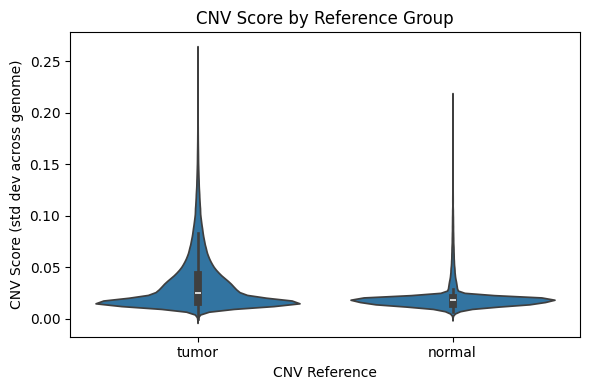

In [36]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=adata.obs, x="cnv_reference", y="cnv_score", scale="width", inner="box")
plt.title("CNV Score by Reference Group")
plt.ylabel("CNV Score (std dev across genome)")
plt.xlabel("CNV Reference")
plt.tight_layout()
plt.show()

In [ ]:
# Check which of these genes are present in the data
available_genes = [gene for gene in proto_oncogenes if gene in adata.var_names]
missing_genes = list(set(proto_oncogenes) - set(available_genes))

print(f"Genes found: {available_genes}")
print(f"Genes missing: {missing_genes}")

# Compute proto-oncogene score: mean expression across available genes
adata.obs["proto_oncogenescore"] = adata[:, available_genes].X.mean(axis=1)

✅ Genes found: ['MYC', 'KRAS', 'EGFR', 'BRAF', 'AKT1', 'PIK3CA', 'CCND1', 'ERBB2', 'FGFR1', 'MDM2']
❌ Genes missing: []


In [ ]:
adata.obs.to_csv(f"{assets}/GSE161529/GSE161529_obs.csv")

In [ ]:
adata.var.to_csv(f"{assets}/GSE161529/GSE161529_var.csv")

##### All the codes above are for adding features to GSE161529 saved as csv which was used for GSE161529 cross-validation in Collab.